,ID,m_sol,p_sol,SMILES,ROMol
0,"1,1,1,2-Tetrachloroethane",-2.18,-2.794,ClCC(Cl)(Cl)Cl,
1,"1,1,1-Trichloroethane",-2.00,-2.232,CC(Cl)(Cl)Cl,
2,"1,1,2,2-Tetrachloroethane",-1.74,-2.549,ClC(Cl)C(Cl)Cl,
3,"1,1,2-Trichloroethane",-1.48,-1.961,ClCC(Cl)Cl,
4,"1,1,2-Trichlorotrifluoroethane",-3.04,-3.077,FC(F)(Cl)C(F)(Cl)Cl,

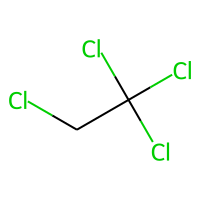
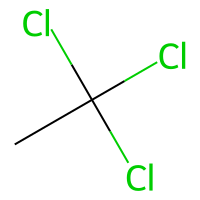
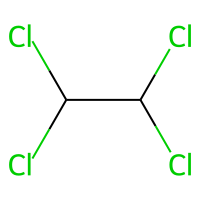
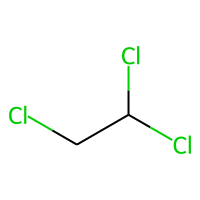
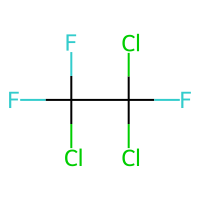

In [1]:
from rdkit import rdBase, Chem
from rdkit.Chem import AllChem, Draw, PandasTools, Descriptors
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import urllib.request 
url = 'https://raw.githubusercontent.com/HIPS/neural-fingerprint/master/data/2015-05-24-delaney/ci034243xsi20040112_053635.txt'
urllib.request.urlretrieve(url, 'water_solubility.txt') 
df = pd.read_csv('water_solubility.txt', sep=',') 
PandasTools.AddMoleculeColumnToFrame(frame=df, smilesCol='smiles')
df.columns = ['ID', 'm_sol', 'p_sol', 'SMILES', 'ROMol']
df.head()

In [2]:
mols = [Chem.MolFromSmiles(i) for i in df['SMILES']]

maccskeys = []
for m in mols:
    maccskey = [x for x in AllChem.GetMACCSKeysFingerprint(m)]
    maccskeys.append(maccskey)
X = np.array(maccskeys)
y = df['m_sol']

In [5]:
import itertools
def calc_interactions(ls):
    one_list = ls[0]
    npList = np.array(ls)
    inter_list = [(npList[:, v[0]]*npList[:, v[1]])
                  for v in (itertools.combinations((range(len(one_list))), 2))]


    inter_list = np.array(inter_list).T
    combined_array = np.concatenate([npList, inter_list], -1)

    return combined_array

In [7]:
x_train = calc_interactions(X)

In [18]:
x_train.shape

(1144, 14028)

In [8]:
def autoscale(y):
    return (y - y.min()) / (y.max()-y.min())

y_train = autoscale(y)

In [10]:
from sklearn import linear_model
eta0=1/x_train.shape[1]*5

model=linear_model.SGDRegressor(max_iter=1000, 
                                verbose=1,   
                                penalty="l2",
                                alpha=0.2,
                                eta0=eta0,   #should be small enough for successful learning
                                l1_ratio=0,
                                early_stopping=True,
                                n_iter_no_change=50,  #should be large enough for successful learning
                            )

model.fit(x_train,y_train)

-- Epoch 1
Norm: 0.08, NNZs: 9568, Bias: 0.027014, T: 1029, Avg. loss: 0.080537
Total training time: 0.04 seconds.
-- Epoch 2
Norm: 0.10, NNZs: 9568, Bias: 0.038882, T: 2058, Avg. loss: 0.053624
Total training time: 0.09 seconds.
-- Epoch 3
Norm: 0.11, NNZs: 9568, Bias: 0.047674, T: 3087, Avg. loss: 0.044108
Total training time: 0.14 seconds.
-- Epoch 4
Norm: 0.12, NNZs: 9568, Bias: 0.054817, T: 4116, Avg. loss: 0.038580
Total training time: 0.19 seconds.
-- Epoch 5
Norm: 0.13, NNZs: 9568, Bias: 0.060925, T: 5145, Avg. loss: 0.034841
Total training time: 0.24 seconds.
-- Epoch 6
Norm: 0.14, NNZs: 9568, Bias: 0.066220, T: 6174, Avg. loss: 0.032102
Total training time: 0.29 seconds.
-- Epoch 7
Norm: 0.14, NNZs: 9568, Bias: 0.070987, T: 7203, Avg. loss: 0.029976
Total training time: 0.34 seconds.
-- Epoch 8
Norm: 0.15, NNZs: 9568, Bias: 0.075367, T: 8232, Avg. loss: 0.028244
Total training time: 0.39 seconds.
-- Epoch 9
Norm: 0.15, NNZs: 9568, Bias: 0.079294, T: 9261, Avg. loss: 0.026806


SGDRegressor(alpha=0.2, early_stopping=True, eta0=0.00035642999714856,
             l1_ratio=0, n_iter_no_change=50, verbose=1)

In [17]:
def QUBO_mat_calc(fp_idx, weight):
    var_dict = {"val"+str(k): v for k, v in enumerate(weight[fp_idx])}
    bit_length = len(fp_idx)
    interaction_dict = {v[0]+"*"+v[1]: var_dict[v[0]]*var_dict[v[1]]
                        for v in itertools.combinations(var_dict.keys(), 2)}
    
    var_dict.update(interaction_dict)
    coefficient_dict = {k: v for k, v in zip(var_dict.keys(), weight)}
    QUBO_matrix = np.zeros((bit_length, bit_length))  
    for k, v in zip(coefficient_dict.keys(), coefficient_dict.values()):
        k = k.replace("val", "")

        if k.find("*") < 0:
            QUBO_matrix[int(k)][int(k)] = v
        else:
            i, j = k.split("*")
            QUBO_matrix[int(i)][int(j)] = v
            
    return QUBO_matrix

In [20]:
X.shape[1]

167

In [26]:
QUBO_m = QUBO_mat_calc(list(range(X.shape[1])),model.coef_)
QUBO_m

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.04213943, 0.00539533,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.04182256,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [40]:
import blueqat.wq as wq
def qa_optimize(qubo,t,shots):
    # maximize:1, minimize:-1
    an = wq.Opt()
    if t == 1:
        an.qubo = -qubo
    else:
        an.qubo = qubo
    result = an.sa(shots=shots, sampler="fast")
    en = [i[-1] for i in an.E]
    return result, en
        

In [70]:
%time res, en = qa_optimize(QUBO_m,t=1,shots=10)

CPU times: user 767 ms, sys: 10 ms, total: 777 ms
Wall time: 788 ms


In [71]:
min_energy = min(en)
ideal_bit = res[np.where(en == min_energy)[0][0]]

In [72]:
len(ideal_bit)

167

In [73]:
ideal_bit_r = calc_interactions([ideal_bit])

In [74]:
len(ideal_bit_r[0])

14028

In [75]:
model.predict(ideal_bit_r)

array([1.53546898])

In [76]:
model.predict(x_train).max()

0.9370268964274601